In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import random
from sklearn.decomposition import PCA
from shapely.geometry import LineString, Point
from folium.plugins import Fullscreen, MiniMap
import geoplot as gplt
from shapely import wkt
from mpl_toolkits.mplot3d import Axes3D

<div>
    <span style ="font-size: 30px; font-weight: bold; color: #8EB944">
        Data Preparation
    </span>
    
<hr style="color: #8EB944; height: 3px;background-color: #8EB944;border: none">
</div>

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Load the data


In [2]:
# load the spatial feature map as a geodataframe
spatial_features = gpd.read_file('census_spatial_features.geojson', crs='epsg:4326')

In [3]:
# load the taxi trips
taxi_df = pd.read_csv('clean_taxi_data.csv')

# drop rides with no dropoff location 
taxi_df = taxi_df[taxi_df.dropoff_location.notna()]


# Get a random subset of 100k rows rows, overwrite the variable  with the 14M rows
taxi_df = taxi_df.sample(n=100000, random_state=12).reset_index()

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Format the data for the clustering


In [4]:
spatial_features['census'] = spatial_features.census.astype('int')

In [5]:
# drop  columns that will not be needed for the clustering
taxi_df = taxi_df.drop(columns=['index', 'Unnamed: 0', 'taxi_id','trip_seconds', 'trip_miles', 'fare',
                                'start_day', 'end_day','start_time', 'end_time'])

In [6]:
def map_spatial_features(taxi_df, spatial_features, feature_name, pickup_col, dropoff_col):
    '''Helper function that maps the spatial features to the taxi trips
    Inputs: spatial features geodataframe, taxi trips dataframe ,the spatial feature column name,
            the columns of the pickup and dropoff census tracts
    Outputs: None --> all operations are performed inplace in that taxi trips dataframe'''
    
    # Create a map of census tracts to the specified feature
    feature_map = spatial_features.set_index('census')[feature_name]
    
    # Map census tracts to the feature for pickup and dropoff
    taxi_df[f'pickup_{feature_name}'] = taxi_df[pickup_col].map(feature_map)
    taxi_df[f'dropoff_{feature_name}'] = taxi_df[dropoff_col].map(feature_map)

In [7]:
# map the spatial features to each ride
map_spatial_features(taxi_df, spatial_features, 'dist_centre', 'pickup_census', 'dropoff_census')
map_spatial_features(taxi_df, spatial_features, 'min_dist_airport', 'pickup_census', 'dropoff_census')
map_spatial_features(taxi_df, spatial_features, 'num_hotels', 'pickup_census', 'dropoff_census')
map_spatial_features(taxi_df, spatial_features, 'num_bars', 'pickup_census', 'dropoff_census')
map_spatial_features(taxi_df, spatial_features, 'num_stadiums', 'pickup_census', 'dropoff_census')
map_spatial_features(taxi_df, spatial_features, 'airport_in_census', 'pickup_census', 'dropoff_census')
map_spatial_features(taxi_df, spatial_features, 'perc_resid', 'pickup_census', 'dropoff_census')
map_spatial_features(taxi_df, spatial_features, 'perc_commerc', 'pickup_census', 'dropoff_census')
map_spatial_features(taxi_df, spatial_features, 'perc_transport', 'pickup_census', 'dropoff_census')
map_spatial_features(taxi_df, spatial_features, 'perc_open', 'pickup_census', 'dropoff_census')


<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Format the spatial features / create temporal features


In [8]:
### format the features ###
#extract the latitude and longitude from the pickup and dropoff locations
taxi_df[['lat_pickup', 'long_pick']] = taxi_df['pickup_location'].str.extract(r'POINT \(([-\d\.]+) ([-\d\.]+)\)')
taxi_df[['lat_dropoff', 'long_dropoff']] = taxi_df['dropoff_location'].str.extract(r'POINT \(([-\d\.]+) ([-\d\.]+)\)')

# convert the  string to time objects
taxi_df['trip_start'] = pd.to_datetime(taxi_df['trip_start'])
taxi_df['trip_end'] = pd.to_datetime(taxi_df['trip_end'])

# extract the hours
taxi_df['pickup_hour'] = taxi_df['trip_start'].dt.hour
taxi_df['dropoff_hour'] = taxi_df['trip_end'].dt.hour

# extract whether the ride was on a weekend
taxi_df['pickup_weekend'] =  taxi_df['trip_start'].dt.weekday.isin([5, 6]).astype(int)
taxi_df['dropoff_weekend'] =  taxi_df['trip_end'].dt.weekday.isin([5, 6]).astype(int)

### create expressive hourly resolutions ###
# morning commuting 
taxi_df['pickup_morning_commuting'] = taxi_df['pickup_hour'].apply(lambda x: 1 if 6 <= x <= 10 else 0)
taxi_df['dropoff_morning_commuting'] = taxi_df['dropoff_hour'].apply(lambda x: 1 if 6 <= x <= 10 else 0)

# Morning commuting on weekdays (1 if weekend = 0 and morning commuting = 1). 
# We overwrite the morning commuting variables created above, as only morning commuting on weekdays is irrelevant from our POV.

taxi_df['pickup_morning_commuting'] = taxi_df['pickup_morning_commuting'] * (1 - taxi_df['pickup_weekend'])
taxi_df['dropoff_morning_commuting'] = taxi_df['dropoff_morning_commuting'] * (1 - taxi_df['dropoff_weekend'])

# afternoon commuting
taxi_df['pickup_afternoon_commuting'] = taxi_df['pickup_hour'].apply(lambda x: 1 if 14 <= x <= 18 else 0)
taxi_df['dropoff_afternoon_commuting'] = taxi_df['dropoff_hour'].apply(lambda x: 1 if 14 <= x <= 18 else 0)

# Afternoon commuting on weekdays (1 if weekend = 0 and afternoon commuting = 1). 
# We overwrite the afternoon commuting variables created above, as only afternoon commuting on weekdays is irrelevant from our POV.
taxi_df['pickup_afternoon_commuting'] = taxi_df['pickup_afternoon_commuting'] * (1 - taxi_df['pickup_weekend'])
taxi_df['dropoff_afternoon_commuting'] = taxi_df['dropoff_afternoon_commuting'] * (1 - taxi_df['dropoff_weekend'])


# bar hours
taxi_df['pickup_bar_hours'] = taxi_df['pickup_hour'].apply(lambda x: 1 if (20 <= x <= 23 or 0 <= x <= 4) else 0)
taxi_df['dropoff_bar_hours'] = taxi_df['dropoff_hour'].apply(lambda x: 1 if (20 <= x <= 23 or 0 <= x <= 4) else 0)


# drop the features that are not needed anymore
taxi_df = taxi_df.drop(columns=['pickup_location', 'dropoff_location', 'pickup_census', 'dropoff_census',\
                               'trip_end', 'trip_start'])

Due to the circularity of time, we do not include the hour variable. We argue that it does not add any additional explanatory power, as we already have 3 discrete expressive hourly resolution (morning- and afternoon commuting and bar hours). When each of the 3 binary variables is 0, the time of the trip was either 11,12,13,19 or 5. We need not create an additional discrete variable for these residual hours and we cannot think of expressive hourly resolutions for these either.

<div>
    <span style ="font-size: 30px; font-weight: bold; color: #8EB944">
        Scaling of the data
    </span>
    
<hr style="color: #8EB944; height: 3px;background-color: #8EB944;border: none">
</div>

In [9]:
# features to be scaled and included in the clustering
features = ['pickup_dist_centre', 'dropoff_dist_centre', 'pickup_min_dist_airport',
       'dropoff_min_dist_airport', 'pickup_num_hotels', 'dropoff_num_hotels',
       'pickup_num_bars', 'dropoff_num_bars', 'pickup_num_stadiums',
       'dropoff_num_stadiums', 'pickup_airport_in_census',
       'dropoff_airport_in_census', 'pickup_perc_resid', 'dropoff_perc_resid',
       'pickup_perc_commerc', 'dropoff_perc_commerc', 'pickup_perc_transport',
       'dropoff_perc_transport', 'pickup_perc_open', 'dropoff_perc_open',
       'lat_pickup', 'long_pick', 'lat_dropoff', 'long_dropoff',
       'pickup_morning_commuting', 'dropoff_morning_commuting',
       'pickup_afternoon_commuting', 'dropoff_afternoon_commuting',
       'pickup_bar_hours', 'dropoff_bar_hours', 'pickup_weekend', 'dropoff_weekend']

# scale the rides with the standard scaler
rides_scaled = StandardScaler().fit_transform(taxi_df[features])

In [10]:
# display the shape of the scaled features
rides_scaled.shape

(100000, 32)

<div>
    <span style ="font-size: 30px; font-weight: bold; color: #8EB944">
        PCA Analysis
    </span>
    
<hr style="color: #8EB944; height: 3px;background-color: #8EB944;border: none">
</div>

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Determine the optimal number of principal components


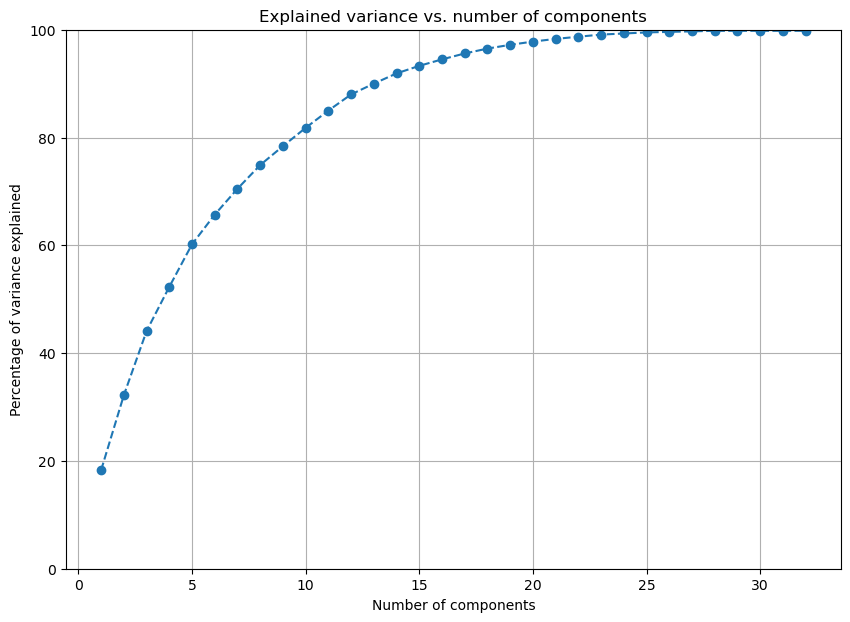

In [11]:
# Create a plot that shows how much of the variance is explained by adding additional components
pca = PCA()
pca.fit(rides_scaled)
per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)

plt.figure(figsize = (10,7))
plt.plot(range(1, len(per_var)+1), per_var.cumsum(), marker = "o", linestyle = "--")
plt.grid()
plt.ylim(0,100)


plt.ylabel("Percentage of variance explained")
plt.xlabel("Number of components")
plt.title("Explained variance vs. number of components")
plt.show()

In [12]:
# get cumulative variance from the PCA analysis
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Determine the number of components that explain at least 90% of the variance
optimal_components = next(i for i, total_variance in enumerate(cumulative_variance) if total_variance >= 0.90) + 1
print(f'The optimal number of principal components is {optimal_components}.')

The optimal number of principal components is 14.


<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Display the composition of the principal components


In [13]:
# choose number of components according to the previous analysis
pca = PCA(n_components = 14)

# Fit the model on the scaled rides
pca.fit(rides_scaled)
scores_pca = pca.transform(rides_scaled)

# Inspect the PCA components
components = pca.components_

# Create a DataFrame for better readability of the features
pca_df = pd.DataFrame(components, columns=features, index=[f'PC{i+1}' for i in range(components.shape[0])])
print("PCA Components:")
print(pca_df)

PCA Components:
      pickup_dist_centre  dropoff_dist_centre  pickup_min_dist_airport  \
PC1             0.348989             0.238366                -0.279559   
PC2            -0.190715             0.339669                 0.208477   
PC3            -0.049646             0.019336                 0.193914   
PC4             0.028272             0.014059                 0.000591   
PC5             0.023264             0.023963                 0.119078   
PC6            -0.025113            -0.038836                 0.034533   
PC7            -0.025211            -0.076754                -0.150718   
PC8            -0.067753            -0.016493                 0.007800   
PC9             0.039069            -0.008264                 0.032932   
PC10            0.014669             0.030971                -0.128838   
PC11           -0.007369             0.009607                -0.050647   
PC12            0.060191             0.048264                 0.099148   
PC13           -0.0173

<div>
    <span style ="font-size: 30px; font-weight: bold; color: #8EB944">
        Soft clustering with Gaussian Mixture Models
    </span>
    
<hr style="color: #8EB944; height: 3px;background-color: #8EB944;border: none">
</div>

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Create an ellbow plot to determine the range for the optimal number of clusters


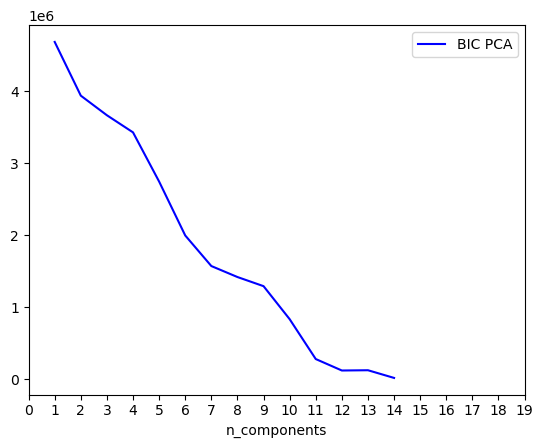

In [14]:
# Use the ellbow method to determine a range for the optimal number of clusters
n_components = np.arange(1, 15)
models1 = [GaussianMixture(n, covariance_type='full', random_state=0).fit(scores_pca)
          for n in n_components]

# plot the bayesian information criterion for the different number of clusters
plt.plot(n_components, [m1.bic(scores_pca) for m1 in models1], label='BIC PCA', color='blue')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(range(0, 20, 1));

<div class="alert alert-block alert-warning">
<b>Note:</b> The ellbow plot is only sufficient for determining the range of the optimal number of clusters. Other methods like silhouette score may be used to determine the optimal number of clusters. However, calculating the silhouette scores for GMM with a sample of 100k rides already took more than 25 minutes. For this reason, we refrain from including this further analysis here and choose the number of cluster in the ellbow, in this case 11 clusters. 
</div>

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Fit the GMM with 11 clusters and the PCA features


In [15]:
# Apply Gaussian Mixture Model with n_components=11 and the PCA features
gmm = GaussianMixture(covariance_type = 'full',n_components = 11, random_state = 0)  
gmm.fit(scores_pca)
labels = gmm.predict(scores_pca)
# create a new dataframe with all the features 
gmm_df = taxi_df[[*features]].copy()

# add the cluster labels to the new dataframe
gmm_df['cluster'] = labels.astype(str)

In [16]:
# convert the gps coordinates and the cluster label to float/int
gmm_df['lat_pickup'] = gmm_df['lat_pickup'].astype(float)
gmm_df['long_pick'] = gmm_df['long_pick'].astype(float)
gmm_df['lat_dropoff'] = gmm_df['lat_dropoff'].astype(float)
gmm_df['long_dropoff'] = gmm_df['long_dropoff'].astype(float)
gmm_df['cluster'] = gmm_df['cluster'].astype(int)

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Create shapely geometries for each trip (for visualization)


In [17]:
def create_geometry(row):
    ''' Function to create LineString for the pickup and dropoff coordinate or a buffered Point (Polygon)
    if start and end coordinates are equal'''
    
    if (row['lat_pickup'], row['long_pick']) == (row['lat_dropoff'], row['long_dropoff']):
        # Create a small buffer around the point to make it visible as a circle
        # this will automatically create a polygon
        return Point(row['long_pick'], row['lat_pickup']).buffer(0.001)
        
    else:
        return LineString([(row['long_pick'], row['lat_pickup']), (row['long_dropoff'], row['lat_dropoff'])])

In [18]:
# Aggregate the data by pickup and dropoff coordinates and cluster and count their occurence
agg_gmm = gmm_df.groupby(['lat_pickup', 'long_pick', 'lat_dropoff', 'long_dropoff', 'cluster']).size().reset_index(name='count')


# Apply the function created in the cell above to create the geometry for all trips
agg_gmm['geometry'] = agg_gmm.apply(create_geometry, axis=1)

# Convert to a GeoDataFrame
gmm_gdf = gpd.GeoDataFrame(agg_gmm, geometry='geometry', crs='epsg:4326')

In [19]:
# take a look at geodataframe
gmm_gdf.head()

,lat_pickup,long_pick,lat_dropoff,long_dropoff,cluster,count,geometry
0,-87.90304,41.979071,-87.903040,41.979071,5,758,"POLYGON ((41.98007 -87.90304, 41.98007 -87.903..."
1,-87.90304,41.979071,-87.901886,42.005560,2,2,"LINESTRING (41.97907 -87.90304, 42.00556 -87.9..."
2,-87.90304,41.979071,-87.901886,42.005560,3,4,"LINESTRING (41.97907 -87.90304, 42.00556 -87.9..."
3,-87.90304,41.979071,-87.844359,41.975338,2,2,"LINESTRING (41.97907 -87.90304, 41.97534 -87.8..."
4,-87.90304,41.979071,-87.844359,41.975338,3,6,"LINESTRING (41.97907 -87.90304, 41.97534 -87.8..."


<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Calculate the centroid for each cluster


In [20]:
# calculate the centroid for each cluster
gmm_cluster_centroids = gmm_df[[*features,'cluster']].groupby('cluster').mean(numeric_only = True)


# calculate the centroid for the entire sample 
overall_centroid = gmm_df[[*features,'cluster']].mean(numeric_only = True).to_frame().T

# create a dataframe with each cluster and the entire dataframe as columns
gmm_centroid_df = pd.concat([gmm_cluster_centroids, overall_centroid], ignore_index=False).T

# rename the columns
gmm_centroid_df.columns = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5',
              'cluster 6', 'cluster 7', 'cluster 8', 'cluster 9', 'cluster 10', 'entire data']

# drop the cluster row
gmm_centroid_df = gmm_centroid_df.drop(index='cluster', errors='ignore')

In [21]:
gmm_centroid_df

,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,cluster 6,cluster 7,cluster 8,cluster 9,cluster 10,entire data
pickup_dist_centre,374.914894,338.914427,22182.313196,12192.561090,789.779260,5232.723500,1501.745935,4711.847730,538.697382,3282.040046,1916.036766,3689.033690
dropoff_dist_centre,661.108678,735.439367,1307.588416,9522.955639,445.877624,22276.395305,2754.893152,5142.219080,539.732504,4526.556341,2266.023651,3244.297890
pickup_min_dist_airport,15117.275889,15109.540880,439.398827,11122.030827,15200.424315,12241.455537,15544.599039,15149.453325,15381.796008,15284.104941,14549.556654,13858.488620
dropoff_min_dist_airport,15143.978812,15165.447368,15491.250147,13751.723120,14903.740039,442.594261,15894.595755,15731.502715,15412.885951,15726.513333,14017.715760,14630.427370
pickup_num_hotels,10.879050,11.854857,0.000000,0.659398,8.014586,8.179274,7.929355,3.021928,9.078409,3.600019,6.770157,7.086900
dropoff_num_hotels,9.206498,8.376422,8.408798,0.383271,10.972163,0.000000,4.821866,1.508454,9.653318,3.438306,2.998065,6.203720
pickup_num_bars,7.378035,8.146018,0.188270,1.265414,5.340181,5.091060,6.886824,3.833180,7.709824,3.597343,5.544829,5.497280
dropoff_num_bars,7.238457,6.718527,6.362317,1.548496,7.925916,0.179749,5.129996,2.793934,7.818559,3.540954,4.742636,5.417280
pickup_num_stadiums,0.000000,0.000000,0.000000,0.000000,0.000000,0.049561,0.000000,0.000000,0.047175,0.092039,0.244034,0.026710
dropoff_num_stadiums,0.000000,0.000000,0.042522,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.755536,0.038040


<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Get the number of rides in each cluster


In [22]:
gmm_gdf.groupby('cluster')['count'].sum().reset_index()

,cluster,count
0,0,11327
1,1,15998
2,2,6820
3,3,5320
4,4,11244
5,5,4217
6,6,12485
7,7,9759
8,8,7716
9,9,10463


<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Create a spatial visualization for all trips in each cluster


<div class='alert alert-danger'>
    <b>IMPORTANT:</b> This code cell creates a folium map with the clustered trips. Unfortunetely, the notebook would be too large (for github) to run it directly here. Therefore, we have uploaded the folium as a HTML file to github. Alternatively, you can execute the cell and run 'm' in a different cell to display the folium map.    
</div>

In [23]:
# Initialize a folium map centered on Chicago
m = folium.Map(location=[41.8781, -87.6298], zoom_start=13)

''' Iterate over each cluster and create a separate layer for each,
this allows us to filter the clusters in the folium map'''

for cluster in range(len(gmm_gdf['cluster'].unique())):
    
    # Filter the GeoDataFrame for the current cluster and make a copy
    cluster_gdf = gmm_gdf[gmm_gdf['cluster'] == cluster].copy()

    # Calculate scaling factors based on the max count in the cluster
    max_count = cluster_gdf['count'].max()

    # Ensure the scaling is not too extreme by adding a small constant
    line_weight_scale = max_count / 10 if max_count > 0 else 1
    stroke_weight_scale = max_count / 10 if max_count > 0 else 1
    fill_opacity_scale = max_count / 100 if max_count > 0 else 0.1

    # Define a feature group/layer for this cluster
    fg = folium.FeatureGroup(name=f'Cluster {cluster}')

    # Add tooltips displaying the cluster and count
    for _, row in cluster_gdf.iterrows():
        tooltip_text = f"cluster: {cluster}, num_rides: {row['count']}"

        # trips that occured only once should be highlighted
        if row['count'] == 1:
            color = 'red'
        # very common trips should be highlighted
        elif row['count'] >= np.percentile(gmm_gdf['count'], 99.9):
            color = 'blue'
        else:
            color = 'green' if row['geometry'].geom_type == 'LineString' else 'green'

        # trips that occured more often should have higher line weights/ opacity
        line_weight = max(1, row['count'] / line_weight_scale)
        fill_opacity = min(1, row['count'] / fill_opacity_scale)
        stroke_weight = max(1, row['count'] / stroke_weight_scale)

        # add the lines with the formatting to the folium map
        if row['geometry'].geom_type == 'LineString':
            folium.PolyLine(locations=[(coord[0], coord[1]) for coord in row['geometry'].coords],
                            color=color, weight=line_weight,  tooltip=tooltip_text).add_to(fg)

        # add the polygons with the formatting to the folium map
        elif row['geometry'].geom_type == 'Polygon':
            folium.Polygon(locations=[(coord[0], coord[1]) for coord in row['geometry'].exterior.coords],
                           color='black', fill=True, fill_opacity=fill_opacity, weight=stroke_weight,
                           tooltip=tooltip_text).add_to(fg)

    # Add the feature group/layer to the map
    fg.add_to(m)

# Add layer control to select specific clusters
folium.LayerControl().add_to(m)


# Add a fullscreen button
fullscreen = Fullscreen(position="topright")
m.add_child(fullscreen)

# Add a minimap to the map
minimap = MiniMap(toggle_display=True, position="bottomleft")
m.add_child(minimap)

m.save('gmm_clustered_trips.html')

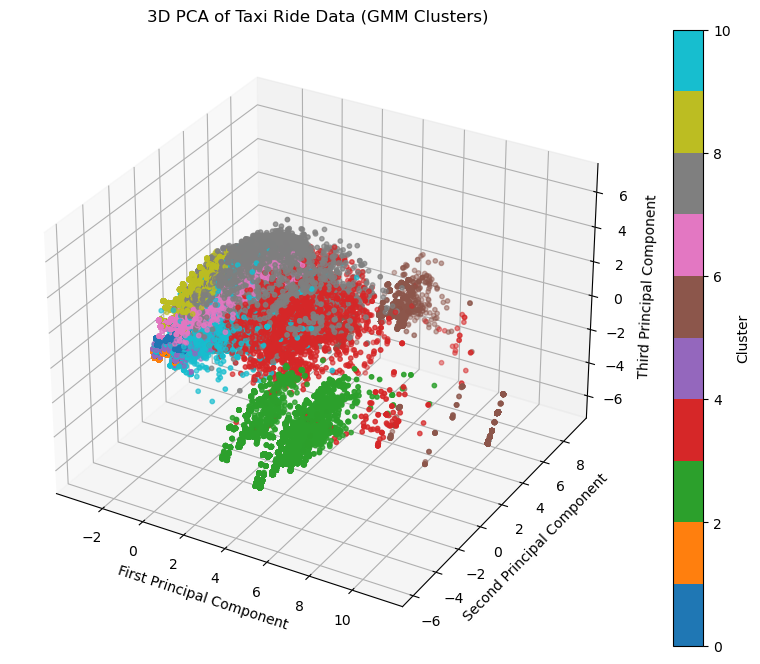

In [24]:
# Assuming scores_pca is the PCA-transformed data and labels are the GMM cluster labels
X_pca = scores_pca[:, :3]  # Use the first 3 PCA components
labels = gmm.predict(scores_pca)  # Or use labels if already defined

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the PCA components, coloring by cluster
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='tab10', s=10)

# Labeling the axes
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')

# Adding a color bar to indicate clusters
plt.colorbar(sc, label='Cluster')
plt.title('3D PCA of Taxi Ride Data (GMM Clusters)')
plt.show()

<div>
    <span style ="font-size: 30px; font-weight: bold; color: #8EB944">
        Hard clustering with KMeans
    </span>
    
<hr style="color: #8EB944; height: 3px;background-color: #8EB944;border: none">
</div>

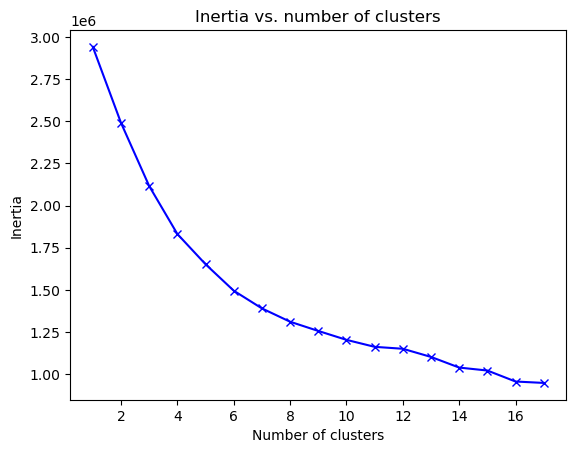

In [25]:
# Use the ellbow method to determine a range for the optimal number of clusters

# init an empty list for the within-cluster sum of squares (inertia) for each number of clusters
inertia = []

# iterate over the number of clusters and calculate the inertia for each model
for n in range(1, 18):
    kmeans = KMeans(n_clusters = n, n_init=10, random_state = 0).fit(scores_pca)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,18), inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs. number of clusters')
plt.show()

We observe that the range for the optimal number of clusters according to the ellbow method is [5,17]. We decide to use 11 clusters, as calculating the silhouette scores or other methods to determine the optimal number of clusters takes more than 20 minutes on our machines. Additionally, we chose 11 clusters as well in the soft clustering part. Thus, we can perfectly compare the results of KMeans and GMM, as both share the same principal components and number of clusters.

In [26]:
# Apply Gaussian Mixture Model with n_components=11 and the PCA features
kmeans = KMeans(n_clusters = 11, n_init=10, random_state = 0).fit(scores_pca)  
kmeans.fit(scores_pca)
labels2 = kmeans.predict(scores_pca)

# create a new dataframe with all the features 
kmeans_df = taxi_df[[*features]].copy()

# add the cluster labels to the new dataframe
kmeans_df['cluster'] = labels2.astype(str)


In [27]:

# convert the gps coordinates and the cluster label to float/int
kmeans_df['lat_pickup'] = kmeans_df['lat_pickup'].astype(float)
kmeans_df['long_pick'] = kmeans_df['long_pick'].astype(float)
kmeans_df['lat_dropoff'] = kmeans_df['lat_dropoff'].astype(float)
kmeans_df['long_dropoff'] = kmeans_df['long_dropoff'].astype(float)
kmeans_df['cluster'] = kmeans_df['cluster'].astype(int)

In [28]:
# Aggregate the data by pickup and dropoff coordinates and cluster and count their occurence
agg_kmeans = kmeans_df.groupby(['lat_pickup', 'long_pick', 'lat_dropoff', 'long_dropoff', 'cluster']).size().reset_index(name='count')


# Apply the function created in the cell above to create the geometry for all trips
agg_kmeans['geometry'] = agg_kmeans.apply(create_geometry, axis=1)

# Convert to a GeoDataFrame
kmeans_gdf = gpd.GeoDataFrame(agg_kmeans, geometry='geometry', crs='epsg:4326')

In [29]:
# take a look at geodataframe
kmeans_gdf.head()

,lat_pickup,long_pick,lat_dropoff,long_dropoff,cluster,count,geometry
0,-87.90304,41.979071,-87.903040,41.979071,9,758,"POLYGON ((41.98007 -87.90304, 41.98007 -87.903..."
1,-87.90304,41.979071,-87.901886,42.005560,9,6,"LINESTRING (41.97907 -87.90304, 42.00556 -87.9..."
2,-87.90304,41.979071,-87.844359,41.975338,6,8,"LINESTRING (41.97907 -87.90304, 41.97534 -87.8..."
3,-87.90304,41.979071,-87.844090,41.972105,6,3,"LINESTRING (41.97907 -87.90304, 41.97210 -87.8..."
4,-87.90304,41.979071,-87.841586,41.982273,6,28,"LINESTRING (41.97907 -87.90304, 41.98227 -87.8..."


<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Calculate the centroid for each cluster


In [30]:
# calculate the centroid for each cluster
kmeans_cluster_centroids = kmeans_df[[*features,'cluster']].groupby('cluster').mean(numeric_only = True)


# calculate the centroid for the entire sample 
overall_centroid2 = kmeans_df[[*features,'cluster']].mean(numeric_only = True).to_frame().T

# create a dataframe with each cluster and the entire dataframe as columns
kmeans_centroid_df = pd.concat([kmeans_cluster_centroids, overall_centroid2], ignore_index=False).T

# rename the columns
kmeans_centroid_df.columns = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5',
              'cluster 6', 'cluster 7', 'cluster 8', 'cluster 9', 'cluster 10', 'entire data']

# drop the cluster row
kmeans_centroid_df = kmeans_centroid_df.drop(index='cluster', errors='ignore')

Get the number of rides per cluster

In [31]:
kmeans_gdf.groupby('cluster')['count'].sum().reset_index()

,cluster,count
0,0,11237
1,1,4976
2,2,3428
3,3,10346
4,4,19984
5,5,13252
6,6,7001
7,7,13684
8,8,12799
9,9,865


<div class='alert alert-danger'>
    <b>IMPORTANT:</b> This code cell creates a folium map with the clustered trips. Unfortunetely, the notebook would be too large (for github) to run it directly here. Therefore, we have uploaded the folium as a HTML file to github. Alternatively, you can execute the cell and run 'm' in a different cell to display the folium map.    
</div>

In [32]:
# Initialize a folium map centered on Chicago
m = folium.Map(location=[41.8781, -87.6298], zoom_start=13)

''' Iterate over each cluster and create a separate layer for each,
this allows us to filter the clusters in the folium map'''

for cluster in range(len(kmeans_gdf['cluster'].unique())):
    
    # Filter the GeoDataFrame for the current cluster and make a copy
    cluster_gdf = kmeans_gdf[kmeans_gdf['cluster'] == cluster].copy()

    # Calculate scaling factors based on the max count in the cluster
    max_count = cluster_gdf['count'].max()

    # Ensure the scaling is not too extreme by adding a small constant
    line_weight_scale = max_count / 10 if max_count > 0 else 1
    stroke_weight_scale = max_count / 10 if max_count > 0 else 1
    fill_opacity_scale = max_count / 100 if max_count > 0 else 0.1

    # Define a feature group/layer for this cluster
    fg = folium.FeatureGroup(name=f'Cluster {cluster}')

    # Add tooltips displaying the cluster and count
    for _, row in cluster_gdf.iterrows():
        tooltip_text = f"cluster: {cluster}, num_rides: {row['count']}"

        # trips that occured only once should be highlighted
        if row['count'] == 1:
            color = 'red'
        # very common trips should be highlighted
        elif row['count'] >= np.percentile(kmeans_gdf['count'], 99.9):
            color = 'blue'
        else:
            color = 'green' if row['geometry'].geom_type == 'LineString' else 'green'

        # trips that occured more often should have higher line weights/ opacity
        line_weight = max(1, row['count'] / line_weight_scale)
        fill_opacity = min(1, row['count'] / fill_opacity_scale)
        stroke_weight = max(1, row['count'] / stroke_weight_scale)

        # add the lines with the formatting to the folium map
        if row['geometry'].geom_type == 'LineString':
            folium.PolyLine(locations=[(coord[0], coord[1]) for coord in row['geometry'].coords],
                            color=color, weight=line_weight,  tooltip=tooltip_text).add_to(fg)

        # add the polygons with the formatting to the folium map
        elif row['geometry'].geom_type == 'Polygon':
            folium.Polygon(locations=[(coord[0], coord[1]) for coord in row['geometry'].exterior.coords],
                           color='black', fill=True, fill_opacity=fill_opacity, weight=stroke_weight,
                           tooltip=tooltip_text).add_to(fg)

    # Add the feature group/layer to the map
    fg.add_to(m)

# Add layer control to select specific clusters
folium.LayerControl().add_to(m)


# Add a fullscreen button
fullscreen = Fullscreen(position="topright")
m.add_child(fullscreen)

# Add a minimap to the map
minimap = MiniMap(toggle_display=True, position="bottomleft")
m.add_child(minimap)

m.save('k-means_clustered_trips.html')



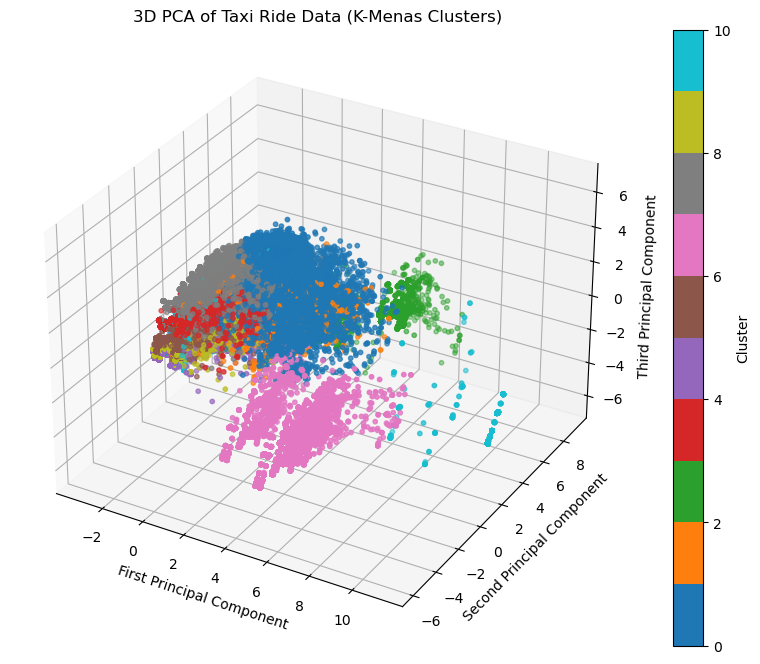

In [33]:
# Assuming scores_pca is the PCA-transformed data and labels are the GMM cluster labels
X_pca = scores_pca[:, :3]  # Use the first 3 PCA components
labels = kmeans.predict(scores_pca)  # Or use labels if already defined

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the PCA components, coloring by cluster
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='tab10', s=10)

# Labeling the axes
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')

# Adding a color bar to indicate clusters
plt.colorbar(sc, label='Cluster')
plt.title('3D PCA of Taxi Ride Data (K-Menas Clusters)')
plt.show()

<div>
    <span style ="font-size: 30px; font-weight: bold; color: #8EB944">
        Identify spatial Hotspots
    </span>
    
<hr style="color: #8EB944; height: 3px;background-color: #8EB944;border: none">
</div>

In [34]:
# load the taxi trips
taxi_df = pd.read_csv('clean_taxi_data.csv')

# drop rides with no dropoff location 
taxi_df = taxi_df[taxi_df.dropoff_location.notna()]

# Get a random subset of 100k rows rows, overwrite the variable  with the 14M rows
taxi_df = taxi_df.sample(n=250000, random_state=12).reset_index()

# convert the location to shapely points
taxi_df.pickup_location = taxi_df.pickup_location.apply(wkt.loads)
taxi_df.dropoff_location = taxi_df.dropoff_location.apply(wkt.loads)

In [35]:
gdf1 = gpd.GeoDataFrame(taxi_df, geometry = 'pickup_location', crs = 'epsg:4326')
gdf2 = gpd.GeoDataFrame(taxi_df, geometry = 'dropoff_location', crs = 'epsg:4326')

In [36]:
# load the census tract data
census = gpd.read_file('Boundaries.geojson', crs = 'epsg:4326')
# load the POI data 
POI = gpd.read_file('POI_data.geojson', crs = 'epsg:4326')

In [37]:
# filter the airports to later include them in the KDE plot
airports = POI[POI.Category == 'Airport']


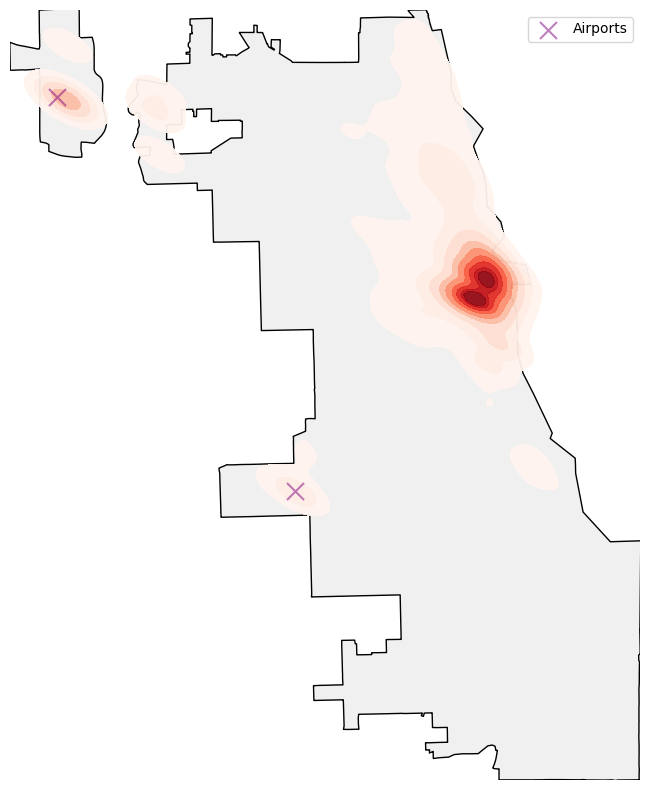

In [38]:
# Define the extent for the Chicago area
chicago_extent = (-87.94011, -87.52413, 41.64454, 42.02304)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the census tracts
census.dissolve().plot(ax = ax, linewidth = 1, color='#F0F0F0', edgecolor = 'black')

# Overlay the KDE plot for the taxi pickups
gplt.kdeplot(gdf1, ax = ax, cmap = "Reds", fill = True, extent=chicago_extent, alpha = 0.95)

airports.plot(ax = ax, marker = 'x', color = 'purple', markersize = 150,  label = 'Airports', alpha = 0.5)

# set the geographic boundaries of the chicago area
ax.set_xlim(chicago_extent[0], chicago_extent[1])
ax.set_ylim(chicago_extent[2], chicago_extent[3])


# Add a legend
ax.legend()

# Show the  plot
plt.show()

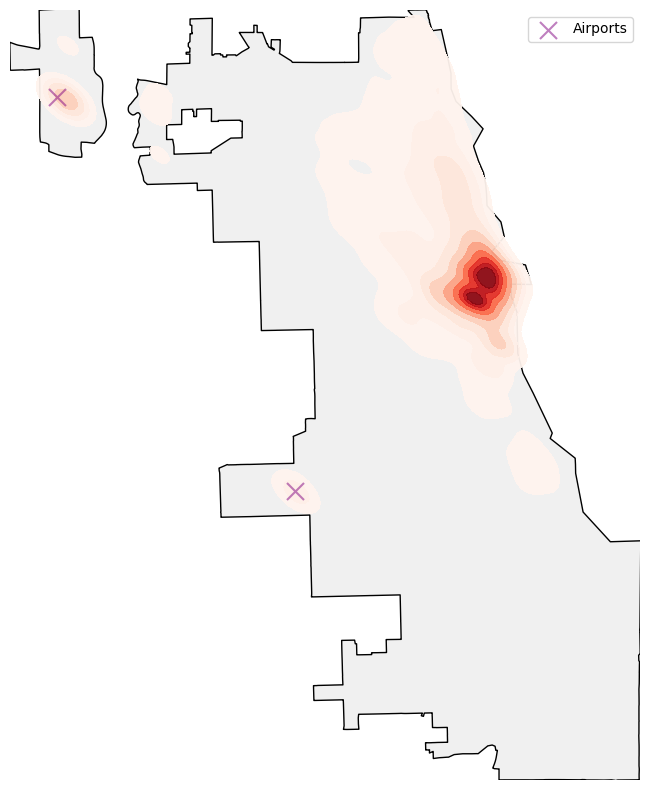

In [39]:
# Define the extent for the Chicago area
chicago_extent = (-87.94011, -87.52413, 41.64454, 42.02304)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the census tracts
census.dissolve().plot(ax = ax, linewidth = 1, color='#F0F0F0', edgecolor = 'black')

# Overlay the KDE plot for the taxi pickups
gplt.kdeplot(gdf2, ax = ax, cmap = "Reds", fill = True, extent=chicago_extent, alpha = 0.95, thresh=0.05)

airports.plot(ax = ax, marker = 'x', color = 'purple', markersize = 150,  label = 'Airports', alpha = 0.5)

# set the geographic boundaries of the chicago area
ax.set_xlim(chicago_extent[0], chicago_extent[1])
ax.set_ylim(chicago_extent[2], chicago_extent[3])


# Add a legend
ax.legend()

# Show the  plot
plt.show()